In [6]:
## Importing all the libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import os
from math import *
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [7]:
## Read the input data files 

path = "C:/Users/XABARBAD/Desktop/Work/KPI Validation & Importance/Model 2/KPI_New_Files/Datasets/"
df = pd.read_excel(path+"Inter_Files.xlsx",sheet_name = "UK_Post_Launch_New")

In [8]:
## Look at the input file
df.head()

Title  \
0                  A Way Out   
1                     Anthem   
2  Assassin's Creed: Odyssey   
3  Assassin's Creed: Origins   
4              Battlefield V   

   Nielsen - Metrics Purchase interest 0 Def not_mean  \
0                                           0.228477    
1                                           0.228218    
2                                           0.169279    
3                                           0.161074    
4                                           0.192688    

   Nielsen - Metrics Purchase interest - Def_mean  \
0                                        0.126327   
1                                        0.110884   
2                                        0.160996   
3                                        0.141040   
4                                        0.139777   

   Nielsen - Metrics First Choice_mean  \
0                             0.001401   
1                             0.006282   
2                             0.004307   
3                             0.008556   
4                             0.007230   

   Nielsen - Metrics Purchase interest - Own/Preorder_mean  \
0                                           0.029054         
1                                           0.039437         
2                                           0.083629         
3                                           0.084600         
4                                           0.080479         

   Nielsen - Metrics Purchase interest - Prob_mean  \
0                                         0.226944   
1                                         0.254875   
2                                         0.360188   
3                                         0.306598   
4                                         0.326984   

   Nielsen - Metrics Unaided Awareness_mean  Google_UK_mean  \
0                                  0.033371        0.921567   
1                                  0.071615        0.213319   
2                                  0.038621        2.866403   
3                                  0.062419        3.262870   
4                                  0.048436        2.747921   

   Marketing Metrics Net Sentiment_mean  \
0                              0.628796   
1                              0.008827   
2                              0.630469   
3                              0.729192   
4                              0.290735   

   Marketing Metrics PR Metrics and Articles_mean  ...  Franchise or Not  \
0                                    14681.047619  ...                 0   
1                                   106440.761905  ...                 0   
2                                   220413.300000  ...                 1   
3                                   128501.428571  ...                 1   
4                                   160702.428571  ...                 1   

   Prem SKU 3 months  Genre_Action_Adventure  Genre_Shooter  Genre_Sports  \
0                  0                       1              0             0   
1                  1                       0              0             0   
2                  1                       0              0             0   
3                  0                       1              0             0   
4                  1                       0              1             0   

   Genre_RP  Genre_Others  Top_Games_3M  Seasonality_Flag  UK_Rev_Group  
0         0             0             6                 0             3  
1         1             0             5                 0             1  
2         1             0             9                 1             2  
3         0             0             5                 1             2  
4         0             0             4                 1             1  

[5 rows x 59 columns]

In [9]:
#Remove titles with no Revenue
df = df[df['UK_Revenue'].notna()]
df.shape

(60, 59)

In [10]:
#### Functions to transform columns

def logTransform(x):
    if(x<=0):
        return 0
    else:
        return log(x)
    
def squareTransform(x):
    return pow(x,2)

def cubeTransform(x):
    return pow(x,3)

def squareRootTransform(x):
    if(x<=0):
        return 0
    else:
        return sqrt(x)

def cubeRootTransform(x):
    if(x<=0):
        return 0
    else:
        return x**(1./3)

In [11]:
#In case there are any missing values, replace them with the mean

def imputeData(df,titleColName):
    df1 = df.drop([titleColName],axis=1)
    imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
    imputer.fit(df1.values)
    df2 = pd.DataFrame(imputer.transform(df1))
    df2.columns = df1.columns
    df2.index = df1.index
    df3 = pd.concat([df[[titleColName]],df2],axis=1)
    return df3

df = imputeData(df, 'Title')

In [12]:
#Apply transformation to every column in the dataset

def getTransformedDF(df,titleColName):
    df2 = df.drop([titleColName],axis=1)
    cols = df2.columns
    df1 = df2[cols]
    for col in cols:
        df1['log('+col+')'] = df1[col].apply(lambda x:logTransform(x))
        df1['square('+col+')'] = df1[col].apply(lambda x:squareTransform(x))
        df1['cube('+col+')'] = df1[col].apply(lambda x:cubeTransform(x))
        df1['squareRoot('+col+')'] = df1[col].apply(lambda x:squareRootTransform(x))
        df1['cubeRoot('+col+')'] = df1[col].apply(lambda x:cubeRootTransform(x))
    df3 = pd.concat([df[[titleColName]],df1],axis=1)
    return df3

titleColName = 'Title'
df_transformed = getTransformedDF(df,titleColName)
df_transformed.shape

(60, 349)

In [13]:
### Get Col Names in Sequence so as to clearly visualise correlation
### Can be skipped

def getColsListSortedOrder(colsList,cols):
    colsNewList = []
    for stg in colsList:
        for col in cols:
            if(col.find(stg)!=-1):
                colsNewList.append(col)

    for col in cols:
        if col not in colsNewList:
            colsNewList.append(col)
        
    unique_col_list  = []    
    for col in colsNewList:
        if(col not in unique_col_list):
            unique_col_list.append(col)
    
    return unique_col_list

In [14]:
#Get the shape of the dataset
df.shape

(60, 59)

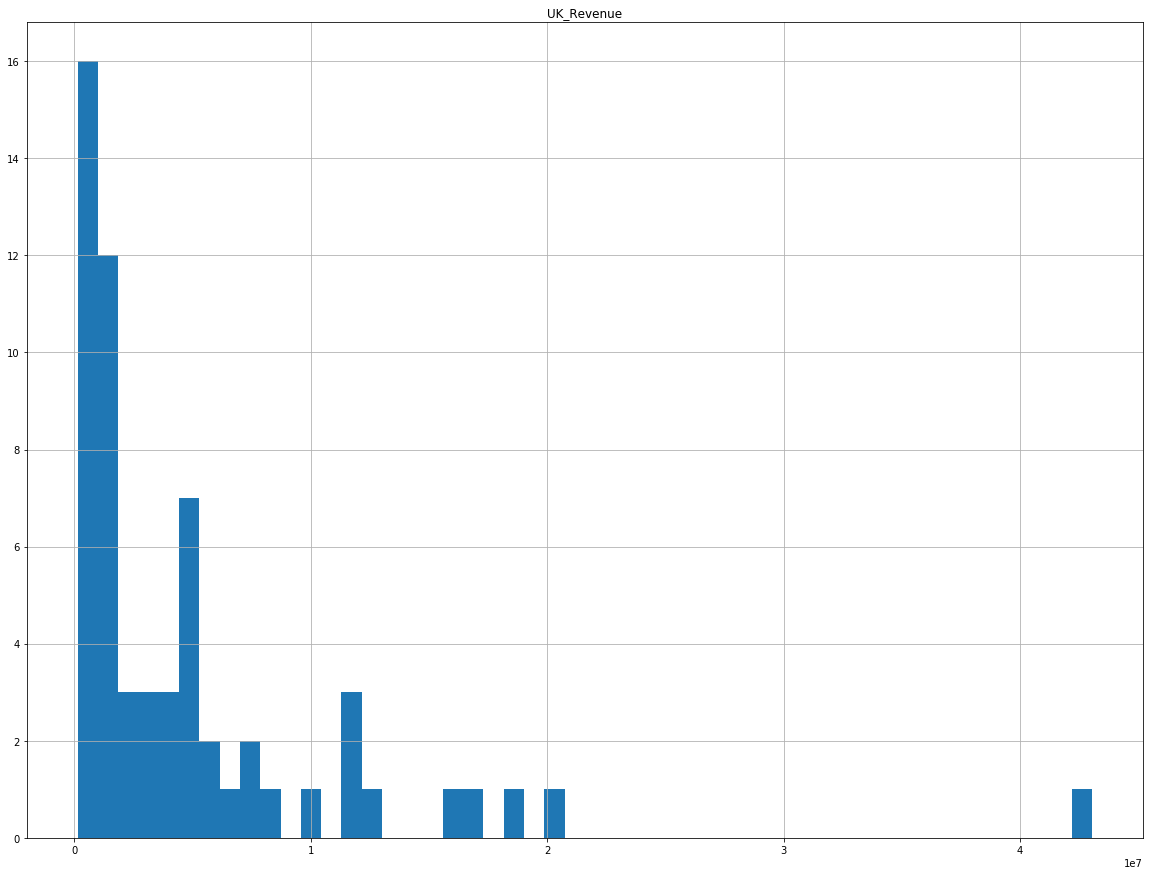

In [15]:
#Checking the distribution in UK Revenue to identify outliers
%matplotlib inline
import matplotlib.pyplot as plt
df_transformed.hist(column = 'UK_Revenue',bins = 50, figsize = (20,15))
plt.show()

In [16]:
#Remove outliers based on business knowledge & the above plot
titles = ['Call of Duty: Modern Warfare 2019']

df_transformed = df_transformed[~df_transformed.Title.isin(titles)]
df_transformed.shape

(59, 349)

In [17]:
#Removing more outliers by removing titles with revenue less than 16M
#16M was identified as the threshold because they had high error & we earlier saw a drop in error by deleting these

#Greater_than2m = df_transformed.UK_Revenue > 16000000
#print(df_transformed[Greater_than2m].shape)
#df_transformed = df_transformed[Greater_than2m]

In [18]:
#### Linear Regression - Model 1
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

def getSplitTrainTest(df_X,df_Y,testSize,seed):
    X_train,X_test,Y_train,Y_test = train_test_split(df_X,df_Y,test_size=testSize,random_state=seed)
    return (X_train,X_test,Y_train,Y_test)

def getLinearModel(X_train,Y_train):
    lr_model_ols = sm.OLS(Y_train.values,X_train.values).fit()
    return (lr_model_ols,X_train.columns)

### Calculate Various Metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def Rsquare(yoriginal,ypred):
    SS_Residual = sum((yoriginal-ypred)**2)
    SS_Total = sum((yoriginal-np.mean(yoriginal))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    return r_squared
def adjRsquare(yoriginal,ypred,rank):
    SS_Residual = sum((yoriginal-ypred)**2)
    SS_Total = sum((yoriginal-np.mean(yoriginal))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    dfResid = len(yoriginal) - rank
    adjusted_r_squared = 1 - (1-r_squared)*(len(yoriginal)-1)/dfResid
    return adjusted_r_squared
def w_mape(y_true,y_pred):
    abs_error_percent = np.abs((y_true- y_pred)/y_true)*100
    return (sum(y_true*abs_error_percent)/sum(y_true))

### For VIF Analysis
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
def variance_inflation_factors(exog_df):
    '''
    Parameters
    ----------
    exog_df : dataframe, (nobs, k_vars)
        design matrix with all explanatory variables, as for example used in
        regression.

    Returns
    -------
    vif : Series
        variance inflation factors
    '''
    exog_df = add_constant(exog_df)
    vifs = pd.Series(
        [1 / (1. - OLS(exog_df[col].values, 
                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
         for col in exog_df],
        index=exog_df.columns,
        name='VIF'
    )
    return vifs

In [19]:
#Dropping title since it's a categorical variable & Revenue because we're checking for Variance inflation & don't
#need the dependent variable

df_revenue_model = df_transformed.drop(['UK_Revenue', 'Title','log(UK_Revenue)','cube(UK_Revenue)',
                                       'squareRoot(UK_Revenue)','cubeRoot(UK_Revenue)','square(UK_Revenue)'], axis = 1)
df_revenue_vif  = df_revenue_model.loc[:].astype(float)
df_revenue_vif.shape

(59, 342)

In [20]:
#Checking the Variance inflation factor of the independent variables
revenue_vif = variance_inflation_factors(df_revenue_vif)
revenue_vif
revenue_vif.shape

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


(343,)

In [21]:
#Another method defined to calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [22]:
#Drop columns with VIF higher than the threshold defined earlier - 5.0

df_vif = calculate_vif_(df_revenue_vif)
df_vif.shape
df_vif.columns

dropping 'cube(Netbase - Metrics Impressions_max)' at index: 259
dropping 'cube(Netbase - Metrics Posts_max)' at index: 268
dropping 'cube(Netbase - Metrics Mentions_mean)' at index: 149
dropping 'square(Marketing Metrics Views_mean)' at index: 113
dropping 'cube(Marketing Metrics Views_mean)' at index: 113
dropping 'cube(Tubular - Metrics Views_mean)' at index: 137
dropping 'cube(Netbase - Metrics Posts_mean)' at index: 150
dropping 'cube(Marketing Metrics PR Metrics and Articles_mean)' at index: 99
dropping 'square(Netbase - Metrics Mentions_max)' at index: 256
dropping 'square(Netbase - Metrics Impressions_max)' at index: 252
dropping 'square(Netbase - Metrics Mentions_mean)' at index: 144
dropping 'cube(Marketing Metrics Twitter Activity_mean)' at index: 108
dropping 'cube(Marketing Metrics Twitter Activity_max)' at index: 216
dropping 'square(Tubular - Metrics Engagements_mean)' at index: 124
dropping 'square(Tubular - Metrics Views_mean)' at index: 133
dropping 'square(Netbase - 

Index(['Nielsen - Metrics Purchase interest 0 Def not_mean',
       'Nielsen - Metrics Purchase interest - Def_mean',
       'Nielsen - Metrics Purchase interest - Own/Preorder_mean',
       'Nielsen - Metrics Purchase interest - Prob_mean',
       'Marketing Metrics Net Sentiment_mean',
       'Netbase - Metrics Impressions_mean',
       'Nielsen - Metrics Purchase interest - Def not_max',
       'Nielsen - Metrics Purchase interest - Def_max',
       'Nielsen - Metrics Purchase interest - Own/Preorder_max',
       'Nielsen - Metrics Purchase interest - Prob_max',
       ...
       'log(Seasonality_Flag)', 'square(Seasonality_Flag)',
       'cube(Seasonality_Flag)', 'squareRoot(Seasonality_Flag)',
       'cubeRoot(Seasonality_Flag)', 'log(UK_Rev_Group)',
       'square(UK_Rev_Group)', 'cube(UK_Rev_Group)',
       'squareRoot(UK_Rev_Group)', 'cubeRoot(UK_Rev_Group)'],
      dtype='object', length=238)

In [23]:
#Checking the sample output

df_vif.head()

Nielsen - Metrics Purchase interest 0 Def not_mean  \
0                                           0.228477    
1                                           0.228218    
2                                           0.169279    
3                                           0.161074    
4                                           0.192688    

   Nielsen - Metrics Purchase interest - Def_mean  \
0                                        0.126327   
1                                        0.110884   
2                                        0.160996   
3                                        0.141040   
4                                        0.139777   

   Nielsen - Metrics Purchase interest - Own/Preorder_mean  \
0                                           0.029054         
1                                           0.039437         
2                                           0.083629         
3                                           0.084600         
4                                           0.080479         

   Nielsen - Metrics Purchase interest - Prob_mean  \
0                                         0.226944   
1                                         0.254875   
2                                         0.360188   
3                                         0.306598   
4                                         0.326984   

   Marketing Metrics Net Sentiment_mean  Netbase - Metrics Impressions_mean  \
0                              0.628796                        1.962728e+08   
1                              0.008827                        7.722310e+08   
2                              0.630469                        3.485387e+09   
3                              0.729192                        2.189637e+09   
4                              0.290735                        2.181563e+09   

   Nielsen - Metrics Purchase interest - Def not_max  \
0                                           0.285984   
1                                           0.274588   
2                                           0.202853   
3                                           0.225014   
4                                           0.224185   

   Nielsen - Metrics Purchase interest - Def_max  \
0                                       0.172758   
1                                       0.164920   
2                                       0.204663   
3                                       0.191555   
4                                       0.175449   

   Nielsen - Metrics Purchase interest - Own/Preorder_max  \
0                                           0.064292        
1                                           0.054767        
2                                           0.103182        
3                                           0.143451        
4                                           0.121979        

   Nielsen - Metrics Purchase interest - Prob_max  ...  log(Seasonality_Flag)  \
0                                        0.284229  ...                    0.0   
1                                        0.327151  ...                    0.0   
2                                        0.431127  ...                    0.0   
3                                        0.392356  ...                    0.0   
4                                        0.408794  ...                    0.0   

   square(Seasonality_Flag)  cube(Seasonality_Flag)  \
0                       0.0                     0.0   
1                       0.0                     0.0   
2                       1.0                     1.0   
3                       1.0                     1.0   
4                       1.0                     1.0   

   squareRoot(Seasonality_Flag)  cubeRoot(Seasonality_Flag)  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           1.0                         1.0   
3                           1.0                         1.0   
4                 

In [24]:
#Wrapper method for variable selection.
#Backward elimination. 

df_rev_only = df_transformed.drop(['Title','log(UK_Revenue)','cube(UK_Revenue)','squareRoot(UK_Revenue)','cubeRoot(UK_Revenue)','square(UK_Revenue)'], axis = 1)
df_rev  = df_rev_only.loc[:].astype(float)
df_rev.shape

#In backward elimination - we only keep variables > 0.5
X = df_rev.drop(['UK_Revenue'], axis = 1)
#X.shape
y_name = "UK_Revenue"
Y = df_rev[y_name]
#Y.shape

In [25]:
#Backward elimination of variables with p-value > 0.05
cols = list(X.columns)
pmax = 1
while (len(cols) > 0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(Y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:], index = cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols
print(selected_features_BE)

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


['Nielsen - Metrics Purchase interest - Def_mean', 'Marketing Metrics Views_mean', 'Tubular - Metrics Views_mean', 'Marketing Metrics UCGs_max', 'Netbase - Metrics Posts_max', 'squareRoot(Nielsen - Metrics Purchase interest 0 Def not_mean)', 'squareRoot(Nielsen - Metrics Purchase interest - Own/Preorder_mean)', 'cubeRoot(Nielsen - Metrics Purchase interest - Prob_mean)', 'squareRoot(Nielsen - Metrics Unaided Awareness_mean)', 'square(Marketing Metrics Views_mean)', 'cube(Marketing Metrics Views_mean)', 'square(Marketing Metrics UCGs_mean)', 'cube(Tubular - Metrics Engagements_mean)', 'cube(Tubular - Metrics Views_mean)', 'log(Netbase - Metrics Totalreposts_mean)', 'squareRoot(Nielsen - Metrics Purchase interest - Def not_max)', 'log(Nielsen - Metrics Purchase interest - Def_max)', 'squareRoot(Nielsen - Metrics First Choice_max)', 'cube(Nielsen - Metrics Purchase interest - Own/Preorder_max)', 'square(Marketing Metrics Twitter Activity_max)', 'log(Marketing Metrics Views_max)', 'cubeRoo

In [26]:
#This part is to identify the top variables to be later used in the model

#What is the ideal set of variables.
#No of features.
#df_rev_complete = df_rev_only

#Importing the relevant packages.
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

nof_list = np.arange(1,13)
high_score = 0

X = df_rev.drop(['UK_Revenue'], axis = 1)
X = X[cols]
#X.shape
y_name = "UK_Revenue"
Y = df_rev[y_name]
Y.shape

#Variable to store the optimum features.
nof = 0
score_list = []
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model, nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    score = model.score(X_test_rfe, y_test)
    score_list.append(score)
    if(score > high_score):
        high_score = score
        nof = nof_list[n]
        
print("Optimum number of features %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features 4
Score with 4 features: 0.845978


In [2]:
#Listing the top variables to be used in the model later
#This is a good point to check which variables make sense to be kept in the model & which to be removed

cols = list(X.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model,25)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)

#Fitting the data to the model
model.fit(X_rfe, Y)
temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp == True].index
print(selected_features_rfe)

In [28]:
#Selecting the top metrics from the above method + business context

cols_vif = [ 'cube(Tubular - Metrics Engagements_mean)','cube(Netbase - Metrics Mentions_mean)',
            'Nielsen - Metrics First Choice_mean','cube(Nielsen - Metrics Purchase interest - Def_mean)',
            'squareRoot(Tubular - Metrics Views_mean)','Google_UK_mean',
            'square(Netbase - Metrics Impressions_mean)', 'log(Netbase - Metrics Posts_mean)',
            'log(Netbase - Metrics Totalreposts_mean)', 'log(Net Sentiment_max)']

In [29]:
#Not a necessary step - Listing out the columns in the original dataset

cols = df_vif.columns.tolist()
cols

['Nielsen - Metrics Purchase interest 0 Def not_mean',
 'Nielsen - Metrics Purchase interest - Def_mean',
 'Nielsen - Metrics Purchase interest - Own/Preorder_mean',
 'Nielsen - Metrics Purchase interest - Prob_mean',
 'Marketing Metrics Net Sentiment_mean',
 'Netbase - Metrics Impressions_mean',
 'Nielsen - Metrics Purchase interest - Def not_max',
 'Nielsen - Metrics Purchase interest - Def_max',
 'Nielsen - Metrics Purchase interest - Own/Preorder_max',
 'Nielsen - Metrics Purchase interest - Prob_max',
 'Nielsen - Metrics Unaided Awareness_max',
 'Google_UK_max',
 'Marketing Metrics Net Sentiment_max',
 'Tubular - Metrics Views_max',
 'No of Platforms',
 'Franchise or Not',
 'Prem SKU 3 months',
 'Genre_Action_Adventure',
 'Genre_Shooter',
 'Genre_Sports',
 'Genre_RP',
 'Genre_Others',
 'Top_Games_3M',
 'Seasonality_Flag',
 'UK_Rev_Group',
 'log(Nielsen - Metrics Purchase interest 0 Def not_mean)',
 'square(Nielsen - Metrics Purchase interest 0 Def not_mean)',
 'cube(Nielsen - Metr

In [30]:
#Subset the dataset & keep only the important variables
df_vif = df_rev[cols_vif]
df_vif.shape

(59, 10)

In [31]:
### For VIF Analysis -- to ensure that the VIF thresholds aren't crossed in the subsetted variables

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
def variance_inflation_factors(exog_df):
    '''
    Parameters
    ----------
    exog_df : dataframe, (nobs, k_vars)
        design matrix with all explanatory variables, as for example used in
        regression.

    Returns
    -------
    vif : Series
        variance inflation factors
    '''
    exog_df = add_constant(exog_df)
    vifs = pd.Series(
        [1 / (1. - OLS(exog_df[col].values, 
                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
         for col in exog_df],
        index=exog_df.columns,
        name='VIF'
    )
    return vifs

In [32]:
#Checking the VIF output
vif = variance_inflation_factors(df_vif)
vif = vif.reset_index()
vif = vif.sort_values(by=['VIF'],ascending=0)
vif

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


index       VIF
3                 Nielsen - Metrics First Choice_mean  1.787639
1            cube(Tubular - Metrics Engagements_mean)  0.999178
2               cube(Netbase - Metrics Mentions_mean)  0.980574
6                                      Google_UK_mean  0.948323
7          square(Netbase - Metrics Impressions_mean)  0.878936
4   cube(Nielsen - Metrics Purchase interest - Def...  0.831735
5            squareRoot(Tubular - Metrics Views_mean)  0.803477
10                             log(Net Sentiment_max)  0.055094
9            log(Netbase - Metrics Totalreposts_mean)  0.048345
8                   log(Netbase - Metrics Posts_mean)  0.027345
0                                               const  0.000000

In [33]:
#Checking for correlation in the dataset
df_vif.corr()

cube(Tubular - Metrics Engagements_mean)  \
cube(Tubular - Metrics Engagements_mean)                                            1.000000   
cube(Netbase - Metrics Mentions_mean)                                              -0.017288   
Nielsen - Metrics First Choice_mean                                                 0.733759   
cube(Nielsen - Metrics Purchase interest - Def_...                                  0.384714   
squareRoot(Tubular - Metrics Views_mean)                                            0.737008   
Google_UK_mean                                                                      0.344747   
square(Netbase - Metrics Impressions_mean)                                          0.092597   
log(Netbase - Metrics Posts_mean)                                                   0.110711   
log(Netbase - Metrics Totalreposts_mean)                                            0.131521   
log(Net Sentiment_max)                                                              0.209389   

                                                    cube(Netbase - Metrics Mentions_mean)  \
cube(Tubular - Metrics Engagements_mean)                                        -0.017288   
cube(Netbase - Metrics Mentions_mean)                                            1.000000   
Nielsen - Metrics First Choice_mean                                             -0.039393   
cube(Nielsen - Metrics Purchase interest - Def_...                              -0.056640   
squareRoot(Tubular - Metrics Views_mean)                                         0.089555   
Google_UK_mean                                                                  -0.078667   
square(Netbase - Metrics Impressions_mean)                                       0.002208   
log(Netbase - Metrics Posts_mean)                                                0.149115   
log(Netbase - Metrics Totalreposts_mean)                                         0.134813   
log(Net Sentiment_max)                                                           0.114728   

                                                    Nielsen - Metrics First Choice_mean  \
cube(Tubular - Metrics Engagements_mean)                                       0.733759   
cube(Netbase - Metrics Mentions_mean)                                         -0.039393   
Nielsen - Metrics First Choice_mean                                            1.000000   
cube(Nielsen - Metrics Purchase interest - Def_...                             0.768487   
squareRoot(Tubular - Metrics Views_mean)                                       0.815365   
Google_UK_mean                                                                 0.695468   
square(Netbase - Metrics Impressions_mean)                                     0.312693   
log(Netbase - Metrics Posts_mean)                                              0.408125   
log(Netbase - Metrics Totalreposts_mean)                                       0.434743   
log(Net Sentiment_max)                                                         0.521913   

                                                    cube(Nielsen - Metrics Purchase interest - Def_mean)  \
cube(Tubular - Metrics Engagements_mean)                                                     0.384714      
cube(Netbase - Metrics Mentions_mean)                                                       -0.056640      
Nielsen - Metrics First Choice_mean                                                          0.768487      
cube(Nielsen - Metrics Purchase interest - Def_...                                           1.000000      
squareRoot(Tubular - Metrics Views_mean)                                                     0.587097      
Google_UK_mean                                                                               0.653836      
square(Netbase - Metrics Impressions_mean)                                                   0.292651      
log(Netbase - Metrics Posts_mean)                                                            0.455528    

In [34]:
#Creating two datasets - X: Only dependent variables, Y: Only independent variables.
X = df_vif.copy()
X.shape
y_name = "UK_Revenue"
Y = df_transformed[y_name]
Y.shape

(59,)

In [35]:
#Checking the values of the revenue dataset
Y

0     1.803156e+06
1     6.129937e+06
2     4.926825e+06
3     5.270505e+06
4     1.148217e+07
5     1.190472e+07
6     1.703465e+07
8     1.159581e+07
9     5.804590e+05
10    1.293969e+07
11    8.649507e+06
12    7.703151e+06
13    1.955285e+06
14    3.214242e+06
15    6.007077e+06
16    3.400956e+06
17    2.056485e+07
19    4.397040e+06
20    1.155799e+06
21    3.995120e+06
22    6.844495e+05
23    1.778157e+06
24    3.751014e+05
25    1.106586e+06
26    6.310320e+06
27    1.436260e+05
28    2.366832e+05
30    1.280053e+06
31    3.532270e+05
33    4.281019e+06
34    1.498890e+06
36    4.524151e+06
37    3.137659e+06
38    4.181164e+05
39    1.470640e+06
40    4.996704e+06
42    5.867537e+05
43    3.559531e+05
44    4.177711e+05
46    2.024871e+06
47    1.846231e+07
48    7.770494e+06
49    1.588831e+06
50    4.872079e+06
51    5.261049e+05
52    2.568370e+06
53    1.491849e+06
54    1.798491e+06
55    1.634807e+07
56    4.736400e+06
57    1.313587e+06
59    7.901814e+05
62    2.7330

In [36]:
#Importing statsmodel library in order to perform Linear Regression

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

def getSplitTrainTest(df_X,df_Y,testSize,seed):
    X_train,X_test,Y_train,Y_test = train_test_split(df_X,df_Y,test_size=testSize,random_state=seed)
    return (X_train,X_test,Y_train,Y_test)

def getLinearModel(X_train,Y_train):
    lr_model_ols = sm.OLS(Y_train.values,X_train.values).fit()
    return (lr_model_ols,X_train.columns)

### Calculate Various Metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def Rsquare(yoriginal,ypred):
    SS_Residual = sum((yoriginal-ypred)**2)
    SS_Total = sum((yoriginal-np.mean(yoriginal))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    return r_squared
def adjRsquare(yoriginal,ypred,rank):
    SS_Residual = sum((yoriginal-ypred)**2)
    SS_Total = sum((yoriginal-np.mean(yoriginal))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    dfResid = len(yoriginal) - rank
    adjusted_r_squared = 1 - (1-r_squared)*(len(yoriginal)-1)/dfResid
    return adjusted_r_squared
def w_mape(y_true,y_pred):
    abs_error_percent = np.abs((y_true- y_pred)/y_true)*100
    return (sum(y_true*abs_error_percent)/sum(y_true))


In [37]:
## Cross Validation Model for both RF and XGB. Uncomment the one which is required
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer

mape_score = make_scorer(mean_absolute_percentage_error)
rsquare_score = make_scorer(Rsquare)
rank = np.linalg.matrix_rank(X)
print("Shape is = ",X.shape)
print("Rank is = ",rank)
adjRsquare_score = make_scorer(adjRsquare,rank = rank)
wmape_score = make_scorer(w_mape)
scoring = {'Rsquare':rsquare_score,'adjRsquare':adjRsquare_score,'mape':mape_score,'wmape':wmape_score}

### Original RF Model
#rf= RandomForestRegressor(n_estimators=1000,max_depth=7,max_features=int(X.shape[1]/3),random_state=7)

### RF model for less than 3 variables
#rf= RandomForestRegressor(n_estimators=1000,max_depth=7,max_features=1,random_state=7)
# rf= RandomForestRegressor(n_estimators=1000,max_depth=7,max_features=int(X.shape[1]/3),random_state=7)
# rf= RandomForestRegressor(n_estimators=2000,max_depth=10,max_features=int(X.shape[1]/3),random_state=7)
# predictions = cross_val_predict(rf,X,Y, cv=4) 
# scores = cross_validate(rf,X,Y,cv=4,scoring = scoring,return_train_score=True,return_estimator=True)

### XGB Model
gbm = xgb.XGBRegressor(n_estimators=25,max_depth=4,max_features=int(X.shape[1]/3),learing_rate=0.001,subsample = 0.55,random_state=7)
predictions = cross_val_predict(gbm,X,Y, cv=4) 
scores = cross_validate(gbm,X,Y,cv=4,scoring = scoring,return_train_score=True,return_estimator=True)


Shape is =  (59, 10)
Rank is =  3
[11:27:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of 

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [38]:
#Checking the scores of the XGB model
scores

{'fit_time': array([0.01296401, 0.00598431, 0.00697732, 0.00598335]),
 'score_time': array([0.01296401, 0.00498605, 0.00498772, 0.00997376]),
 'estimator': (XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               importance_type='gain', learing_rate=0.001, learning_rate=0.1,
               max_delta_step=0, max_depth=4, max_features=3, min_child_weight=1,
               missing=None, n_estimators=25, n_jobs=1, nthread=None,
               objective='reg:linear', random_state=7, reg_alpha=0, reg_lambda=1,
               scale_pos_weight=1, seed=None, silent=None, subsample=0.55,
               verbosity=1),
  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               importance_type='gain', learing_rate=0.001, learning_rate=0.1,
               max_delta_step=0, max_depth=4, max_features=3, min_child_weight=1,
 

In [39]:
#Checking model metrics for the XGBoost model
print("Test mape = ",scores['test_mape'].mean())
print("Train mape= ",scores['train_mape'].mean())
print("Test Wmape = ",scores['test_wmape'].mean())
print("Train Wmape = ",scores['train_wmape'].mean())
print("Train Rsquare = ",scores['train_Rsquare'].mean())
print("Train adjRsquare = ",scores['train_adjRsquare'].mean())

Test mape =  145.5687773229802
Train mape=  42.71711580621373
Test Wmape =  66.22967612615493
Train Wmape =  25.70420935349392
Train Rsquare =  0.844097742050169
Train adjRsquare =  0.8365248962374999


In [40]:
##For Feature Importance of the XGBoost model
df_model_cv_prediction = df_transformed[[y_name]]
feature_importances = pd.DataFrame()
feature_importances['Features'] = X.columns
count = 0
for model in scores['estimator']:
    pred = model.predict(X)
    feat_imp = model.feature_importances_
    df_model_cv_prediction['model_'+str(count)] = pred
    feature_importances['model_'+str(count)] = feat_imp
    count = count+1
df_model_cv_prediction['mean'] = df_model_cv_prediction.mean(axis=1)
feature_importances['mean'] = feature_importances.mean(axis=1)
feature_importances.sort_values('mean',inplace=True,ascending=False)
feature_importances

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Features   model_0   model_1  \
2                Nielsen - Metrics First Choice_mean  0.333971  0.160681   
5                                     Google_UK_mean  0.248799  0.252425   
3  cube(Nielsen - Metrics Purchase interest - Def...  0.046569  0.103799   
6         square(Netbase - Metrics Impressions_mean)  0.099421  0.146508   
4           squareRoot(Tubular - Metrics Views_mean)  0.081723  0.038842   
7                  log(Netbase - Metrics Posts_mean)  0.005727  0.134498   
0           cube(Tubular - Metrics Engagements_mean)  0.069596  0.065825   
1              cube(Netbase - Metrics Mentions_mean)  0.075132  0.038512   
9                             log(Net Sentiment_max)  0.035177  0.042840   
8           log(Netbase - Metrics Totalreposts_mean)  0.003884  0.016071   

    model_2   model_3      mean  
2  0.144187  0.431013  0.267463  
5  0.305099  0.053108  0.214858  
3  0.063360  0.221367  0.108774  
6  0.176093  0.003829  0.106463  
4  0.081114  0.084453  0.071533  
7  0.052208  0.069438  0.065468  
0  0.067674  0.043268  0.061591  
1  0.048137  0.024602  0.046596  
9  0.042507  0.054509  0.043758  
8  0.019621  0.014413  0.013497

In [41]:
#Checking for the error in prediction by comparing model output with the actual values
df_model_cv_prediction['Title'] = df_transformed['Title']
df_model_cv_prediction['Error'] = df_model_cv_prediction.UK_Revenue - df_model_cv_prediction['mean']
df_model_cv_prediction['AbsError'] = abs(df_model_cv_prediction['Error'])
df_model_cv_prediction['PercentError'] = (df_model_cv_prediction['AbsError']/df_model_cv_prediction.UK_Revenue)*100
df_model_cv_prediction = df_model_cv_prediction.sort_values(by = 'PercentError',ascending=False)
df_model_cv_prediction

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is t

UK_Revenue       model_0       model_1       model_2       model_3  \
44  4.177711e+05  2.197830e+06  3.085037e+06  6.157919e+06  1.029025e+06   
59  7.901814e+05  2.242256e+06  2.463802e+06  2.288832e+06  1.298744e+07   
31  3.532270e+05  7.597276e+05  2.840743e+06  6.727991e+05  8.104341e+05   
27  1.436260e+05  3.140858e+05  7.187898e+05  5.098753e+05  3.070053e+05   
69  7.519201e+05  1.227045e+06  1.914537e+06  1.328326e+06  5.169376e+06   
24  3.751014e+05  7.595835e+05  1.940410e+06  6.200786e+05  7.732132e+05   
51  5.261049e+05  1.050560e+06  1.236544e+06  1.671186e+06  8.243063e+05   
38  4.181164e+05  6.338965e+05  7.187664e+05  1.528204e+06  7.030076e+05   
39  1.470640e+06  2.978807e+06  1.870320e+06  4.889429e+06  2.531989e+06   
20  1.155799e+06  1.467258e+06  2.991387e+06  2.462453e+06  2.369016e+06   
28  2.366832e+05  3.522420e+05  5.984278e+05  4.262940e+05  4.447143e+05   
21  3.995120e+06  5.893408e+06  1.228106e+07  6.296186e+06  5.146448e+06   
43  3.559531e+05  4.513965e+05  6.051554e+05  8.366894e+05  6.260341e+05   
49  1.588831e+06  1.864656e+06  2.459502e+06  4.126969e+06  2.153049e+06   
70  6.870241e+05  1.008805e+06  9.472136e+05  8.612468e+05  1.686873e+06   
1   6.129937e+06  1.647959e+06  4.052309e+06  3.311252e+06  4.222724e+06   
13  1.955285e+06  4.046721e+06  2.268212e+06  2.480470e+06  2.469867e+06   
6   1.703465e+07  3.561160e+06  1.026915e+07  1.138438e+07  1.303403e+07   
17  2.056485e+07  1.325144e+07  8.932998e+06  1.072819e+07  1.380759e+07   
23  1.778157e+06  9.510632e+05  8.490808e+05  1.199759e+06  1.052337e+06   
62  2.733039e+05  2.662010e+05  4.483567e+05  3.328576e+05  4.989371e+05   
66  4.839652e+06  3.813011e+06  3.194626e+06  3.126038e+06  1.236973e+06   
10  1.293969e+07  5.767448e+06  8.020558e+06  8.703114e+06  8.880886e+06   
34  1.498890e+06  8.835624e+05  9.841271e+05  7.983011e+05  1.004222e+06   
47  1.846231e+07  1.061037e+07  1.270405e+07  9.032694e+06  1.398918e+07   
68  6.775460e+05  7.488604e+05  1.114051e+06  8.650577e+05  9.910722e+05   
56  4.736400e+06  5.206996e+06  6.185706e+06  6.164382e+06  7.981755e+06   
63  1.834700e+06  1.217996e+06  1.437469e+06  1.319435e+06  9.051521e+05   
5   1.190472e+07  5.070054e+06  8.415984e+06  9.026898e+06  9.845994e+06   
67  9.947781e+06  7.819236e+06  7.225020e+06  7.796646e+06  4.510267e+06   
36  4.524151e+06  3.369255e+06  2.745216e+06  2.563514e+06  3.844949e+06   
46  2.024871e+06  1.194569e+06  1.537241e+06  1.542844e+06  1.560104e+06   
26  6.310320e+06  4.706266e+06  3.779223e+06  4.789947e+06  5.003267e+06   
33  4.281019e+06  4.876492e+06  6.760879e+06  4.840528e+06  5.342558e+06   
40  4.996704e+06  4.174971e+06  3.826588e+06  3.307281e+06  3.382640e+06   
54  1.798491e+06  1.315184e+06  1.238510e+06  1.379306e+06  1.424875e+06   
55  1.634807e+07  1.212670e+07  1.394542e+07  1.332420e+07  1.025197e+07   
52  2.568370e+06  1.958473e+06  1.992936e+06  2.042707e+06  2.139846e+06   
15  6.007077e+06  9.463028e+06  6.612646e+06  6.517224e+06  6.430756e+06   
9   5.804590e+05  8.021221e+05  6.282273e+05  8.402112e+05  5.307394e+05   
50  4.872079e+06  3.526113e+06  3.434074e+06  4.266942e+06  4.334107e+06   
48  7.770494e+06  6.877806e+06  6.246717e+06  4.290995e+06  7.459169e+06   
8   1.159581e+07  5.715288e+06  1.070767e+07  9.831772e+06  1.130356e+07   
4   1.148217e+07  8.186603e+06  9.485726e+06  1.051315e+07  9.113308e+06   
11  8.649507e+06  4.665258e+06  7.842996e+06  8.280493e+06  7.412274e+06   
22  6.844495e+05  7.318924e+05  8.490808e+05  8.499881e+05  7.919254e+05   
42  5.867537e+05  5.729039e+05  6.304928e+05  8.982827e+05  6.541679e+05   
16  3.400956e+06  3.015673e+06  2.512645e+06  3.125964e+06  3.127808e+06   
3   5.270505e+06  6.613714e+06  5.324860e+06  6.054292e+06  5.872793e+06   
30  1.280053e+06  1.123521e+06  2.020396e+06  1.400251e+06  1.185588e+06   
37  3.137659e+06  2.481678e+06  2.708585e+06  2.869004e+06  3.036152e+06   
14  3.214242e+06  3.759597e+06  3.083078e+06  3.062428

In [42]:
### Cross Validation for Linear Regression
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer
mape_score = make_scorer(mean_absolute_percentage_error)
rsquare_score = make_scorer(Rsquare)
rank = np.linalg.matrix_rank(df_vif)
print(df_vif.shape)
print(rank)
adjRsquare_score = make_scorer(adjRsquare,rank = rank)
wmape_score = make_scorer(w_mape)
scoring = {'Rsquare':rsquare_score,'adjRsquare':adjRsquare_score,'mape':mape_score,'wmape':wmape_score}
lm= linear_model.LinearRegression()
np.random.seed(7)
predictions = cross_val_predict(lm, df_vif,df_transformed['UK_Revenue'], cv=8) 
#print(predictions)
scores = cross_validate(lm,df_vif,df_transformed['UK_Revenue'],cv=8,scoring = scoring,return_train_score=True,return_estimator=True)

(59, 10)
3


In [43]:
#Exporting the model output
df_model_cv_prediction[['UK_Revenue','mean']].to_excel(path+"//Post_Launch_Pred_UK_0625.xlsx")

In [44]:
#Creating a plot to check for actual vs Prediction: XGBoost model
print(scores['estimator'][0].predict(df_vif))
scores['estimator'][0].intercept_

[ 2827823.71613406  2864229.40553098  3626799.55706958  3142098.27558214
  3140390.19683806  2964853.40555983  5677210.52871631  5026639.27275296
  2837560.38128744  2984629.98103068 12328154.20242786  3887373.78013165
  3051323.26053655  2886411.2954078   3150549.10113387  2845290.86441437
 20058690.01203946  3122065.08498681  2952819.59164943  4742619.16831458
  2825479.2006716   2825453.53013168  2857633.94997184  2854425.59120303
  2898860.82644307  2824862.00436775  2825218.71212185  3040647.07254395
  2858633.94222453  3339599.18024674  2828386.66851868  2979037.70416995
  3092869.9057183   2825001.45331351  2841773.07715362  2853250.50924669
  2827724.24111304  2842787.80882187  8633521.26675089  2861806.86948797
  7090167.34685067  3081235.12270594  3121243.7715593   4531868.23828288
  2872833.89334955  3218850.32615552  2828435.46827985  3072642.67005891
  4455164.85835355  3204315.3627188   2845301.97772969  3098882.15839336
  2825170.1989281   2840342.74108126  2827481.20636

2824843.010601825

In [45]:
#Checking the score of the model
scores

{'fit_time': array([0.00398993, 0.00299144, 0.00099564, 0.00199938, 0.00199509,
        0.00299191, 0.0039773 , 0.00299215]),
 'score_time': array([0.01396275, 0.00898147, 0.00498724, 0.00697803, 0.00598311,
        0.00797844, 0.00797391, 0.00598407]),
 'estimator': (LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)),
 'test_Rsquare': array([-9.29522800e-01, -2.33374341e+00, -8.6995756

In [46]:
#Model error metrics & fit
print(scores['test_wmape'].mean())
print(scores['train_wmape'].mean())
print(scores['train_Rsquare'].mean())
print(scores['train_adjRsquare'].mean())
# print(scores['test_wmape'].mean())
# print(scores['test_wmape'].mean())

148.95177175010545
68.4986882345878
0.3316239607668935
0.3041336448455656


In [47]:
#Checking the output from Linear Regression
scores['estimator'][1].predict(df_vif)
df_model_cv_prediction = df_transformed[['UK_Revenue']]
count = 0
for model in scores['estimator']:
    pred = model.predict(df_vif)
    df_model_cv_prediction['model_'+str(count)] = pred
    count = count+1
df_model_cv_prediction

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

UK_Revenue       model_0       model_1       model_2       model_3  \
0   1.803156e+06  2.827824e+06  2.846804e+06  3.717616e+06  3.678370e+06   
1   6.129937e+06  2.864229e+06  2.933365e+06  3.778690e+06  3.720840e+06   
2   4.926825e+06  3.626800e+06  4.733387e+06  4.958611e+06  4.608444e+06   
3   5.270505e+06  3.142098e+06  3.588171e+06  4.200416e+06  4.044100e+06   
4   1.148217e+07  3.140390e+06  3.583195e+06  4.190942e+06  4.041955e+06   
5   1.190472e+07  2.964853e+06  3.167385e+06  3.909813e+06  3.837344e+06   
6   1.703465e+07  5.677211e+06  9.574648e+06  8.143063e+06  6.995169e+06   
8   1.159581e+07  5.026639e+06  7.988077e+06  6.759820e+06  6.229807e+06   
9   5.804590e+05  2.837560e+06  2.870442e+06  3.737545e+06  3.689807e+06   
10  1.293969e+07  2.984630e+06  3.212423e+06  3.926721e+06  3.860172e+06   
11  8.649507e+06  1.232815e+07  2.525429e+07  1.828693e+07  1.473355e+07   
12  7.703151e+06  3.887374e+06  5.341592e+06  5.312796e+06  4.910563e+06   
13  1.955285e+06  3.051323e+06  3.348997e+06  3.878909e+06  3.934325e+06   
14  3.214242e+06  2.886411e+06  2.985148e+06  3.808891e+06  3.746560e+06   
15  6.007077e+06  3.150549e+06  3.598283e+06  4.140521e+06  4.052378e+06   
16  3.400956e+06  2.845291e+06  2.887938e+06  3.743920e+06  3.698686e+06   
17  2.056485e+07  2.005869e+07  1.963378e+07 -1.469932e+08  1.995744e+07   
19  4.397040e+06  3.122065e+06  3.271354e+06  4.022921e+06  3.892613e+06   
20  1.155799e+06  2.952820e+06  3.142064e+06  3.912697e+06  3.823889e+06   
21  3.995120e+06  4.742619e+06  7.286319e+06  6.085366e+06  5.894368e+06   
22  6.844495e+05  2.825479e+06  2.841920e+06  3.718816e+06  3.675744e+06   
23  1.778157e+06  2.825454e+06  2.841868e+06  3.718839e+06  3.675716e+06   
24  3.751014e+05  2.857634e+06  2.917834e+06  3.768733e+06  3.713170e+06   
25  1.106586e+06  2.854426e+06  2.910208e+06  3.763305e+06  3.709431e+06   
26  6.310320e+06  2.898861e+06  3.014226e+06  3.826214e+06  3.760986e+06   
27  1.436260e+05  2.824862e+06  2.840472e+06  3.717927e+06  3.675027e+06   
28  2.366832e+05  2.825219e+06  2.841312e+06  3.718464e+06  3.675442e+06   
30  1.280053e+06  3.040647e+06  3.349883e+06  4.052263e+06  3.926201e+06   
31  3.532270e+05  2.858634e+06  2.920181e+06  3.770109e+06  3.714335e+06   
33  4.281019e+06  3.339599e+06  4.048779e+06  4.465151e+06  4.273072e+06   
34  1.498890e+06  2.828387e+06  2.848794e+06  3.723395e+06  3.679130e+06   
36  4.524151e+06  2.979038e+06  3.204220e+06  3.955240e+06  3.854450e+06   
37  3.137659e+06  3.092870e+06  3.409011e+06  3.663897e+06  3.976515e+06   
38  4.181164e+05  2.825001e+06  2.840689e+06  3.717413e+06  3.675167e+06   
39  1.470640e+06  2.841773e+06  2.876184e+06  3.712856e+06  3.694046e+06   
40  4.996704e+06  2.853251e+06  2.906831e+06  3.757027e+06  3.707967e+06   
42  5.867537e+05  2.827724e+06  2.847230e+06  3.722363e+06  3.678359e+06   
43  3.559531e+05  2.842788e+06  2.882797e+06  3.745745e+06  3.695894e+06   
44  4.177711e+05  8.633521e+06  1.481115e+07  9.081361e+05  1.010891e+07   
46  2.024871e+06  2.861807e+06  2.927663e+06  3.774958e+06  3.718027e+06   
47  1.846231e+07  7.090167e+06  1.283956e+07  9.859345e+06  8.626268e+06   
48  7.770494e+06  3.081235e+06  3.421481e+06  3.935587e+06  3.969602e+06   
49  1.588831e+06  3.121244e+06  3.539928e+06  4.175469e+06  4.019981e+06   
50  4.872079e+06  4.531868e+06  4.132487e+06  4.857951e+06  4.360860e+06   
51  5.261049e+05  2.872834e+06  2.953711e+06  3.792160e+06  3.730866e+06   
52  2.568370e+06  3.218850e+06  3.770623e+06  4.328635e+06  4.133642e+06   
53  1.491849e+06  2.828435e+06  2.848544e+06  3.720760e+06  3.679129e+06   
54  1.798491e+06  3.072643e+06  3.425063e+06  4.102208e+06  3.963250e+06   
55  1.634807e+07  4.455165e+06  6.681531e+06  6.186899e+06  5.571499e+06   
56  4.736400e+06  3.204315e+06  3.735415e+06  4.300525e+06  4.116533e+06   
57  1.313587e+06  2.845302e+06  2.876231e+06  3.742899e+06  3.692874e+06   
59  7.901814e+05  3.098882e+06  3.483931e+06  4.117614

In [48]:
#Checking the Actual Revenue versus Mean
df_model_cv_prediction['mean'] = df_model_cv_prediction.mean(axis=1)
df_model_cv_prediction[['UK_Revenue','mean']]

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


UK_Revenue          mean
0   1.803156e+06  3.216286e+06
1   6.129937e+06  3.741249e+06
2   4.926825e+06  4.519967e+06
3   5.270505e+06  3.977091e+06
4   1.148217e+07  4.664291e+06
5   1.190472e+07  4.499892e+06
6   1.703465e+07  8.320157e+06
8   1.159581e+07  6.885637e+06
9   5.804590e+05  3.092749e+06
10  1.293969e+07  4.636683e+06
11  8.649507e+06  1.532594e+07
12  7.703151e+06  5.133458e+06
13  1.955285e+06  3.475183e+06
14  3.214242e+06  3.443255e+06
15  6.007077e+06  4.059007e+06
16  3.400956e+06  3.414619e+06
17  2.056485e+07  1.522483e+06
19  4.397040e+06  3.817131e+06
20  1.155799e+06  3.294141e+06
21  3.995120e+06  5.668996e+06
22  6.844495e+05  3.089844e+06
23  1.778157e+06  3.211345e+06
24  3.751014e+05  3.093966e+06
25  1.106586e+06  3.171341e+06
26  6.310320e+06  3.801889e+06
27  1.436260e+05  3.029023e+06
28  2.366832e+05  3.039788e+06
30  1.280053e+06  3.413536e+06
31  3.532270e+05  3.092710e+06
33  4.281019e+06  4.097827e+06
34  1.498890e+06  3.183827e+06
36  4.524151e+06  3.700044e+06
37  3.137659e+06  3.617821e+06
38  4.181164e+05  3.059588e+06
39  1.470640e+06  3.192407e+06
40  4.996704e+06  3.601556e+06
42  5.867537e+05  3.081685e+06
43  3.559531e+05  3.074074e+06
44  4.177711e+05  8.375423e+06
46  2.024871e+06  3.282236e+06
47  1.846231e+07  1.010419e+07
48  7.770494e+06  4.158572e+06
49  1.588831e+06  3.544071e+06
50  4.872079e+06  5.199629e+06
51  5.261049e+05  3.128919e+06
52  2.568370e+06  3.769987e+06
53  1.491849e+06  3.182730e+06
54  1.798491e+06  3.509452e+06
55  1.634807e+07  6.772763e+06
56  4.736400e+06  3.992705e+06
57  1.313587e+06  3.181688e+06
59  7.901814e+05  3.425372e+06
62  2.733039e+05  3.043801e+06
63  1.834700e+06  3.235315e+06
66  4.839652e+06  3.553389e+06
67  9.947781e+06  4.140613e+06
68  6.775460e+05  3.091486e+06
69  7.519201e+05  3.097268e+06
70  6.870241e+05  3.090166e+06

In [49]:
#Exporting the output of the dataset
df_model_cv_prediction[['UK_Revenue','mean']].to_excel(path+"//8foldCV_results_v2_UK_0528.xlsx")

In [50]:
## Cross Validation for Random Forest Regressor
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer

mape_score = make_scorer(mean_absolute_percentage_error)
rsquare_score = make_scorer(Rsquare)
rank = np.linalg.matrix_rank(df_vif)
print(df_vif.shape)
print(rank)
adjRsquare_score = make_scorer(adjRsquare,rank = rank)
wmape_score = make_scorer(w_mape)
scoring = {'Rsquare':rsquare_score,'adjRsquare':adjRsquare_score,'mape':mape_score,'wmape':wmape_score}
rf= RandomForestRegressor(n_estimators=1000,max_depth=7,max_features=int(df_vif.shape[1]/3),random_state=7)
predictions = cross_val_predict(rf, df_vif,df_transformed['UK_Revenue'], cv=8) 
scores = cross_validate(rf,df_vif,df_transformed['UK_Revenue'],cv=8,scoring = scoring,return_train_score=True,return_estimator=True)

(59, 10)
3


In [3]:
#import pandas.rpy.common as com
#Create a correlation plot based on need

#import seaborn as sns
#%matplotlib inline
#corr = df_vif.corr()
#corr.to_excel(path+"\\corr10features.xlsx")
#fig, ax = plt.subplots(figsize=(10, 10))
#mask = np.zeros_like(corr)
#mask[np.triu_indices_from(mask)] = 1
#sns_plot = sns.heatmap(corr,mask=mask,ax=ax,annot=True)
#fig = sns_plot.get_figure()
#fig.savefig(path+"\\corr_plot.png")
#sns_plot
#corr.to_excel(path+"correlation_plot.xlsx")

In [51]:
#Printing feature importance from the RF Regressor model
scores['estimator'][0].feature_importances_

array([0.13581794, 0.04235738, 0.17487012, 0.1167549 , 0.1331227 ,
       0.13461054, 0.08182358, 0.04140617, 0.03369808, 0.1055386 ])

In [52]:
#Print out the model error & r-squared values

print(scores['test_wmape'].mean())
print(scores['train_wmape'].mean())
print(scores['train_Rsquare'].mean())
print(scores['train_adjRsquare'].mean())

63.972958417420216
22.454613025540866
0.9202717574912237
0.9169911268762658


In [53]:
#Export model predictions & feature importances
df_model_cv_prediction = df_transformed[['UK_Revenue']]
feature_importances = pd.DataFrame()
feature_importances['Features'] = df_vif.columns
count = 0
for model in scores['estimator']:
    pred = model.predict(df_vif)
    feat_imp = model.feature_importances_
    df_model_cv_prediction['model_'+str(count)] = pred
    feature_importances['model_'+str(count)] = feat_imp
    count = count+1
df_model_cv_prediction['mean'] = df_model_cv_prediction.mean(axis=1)
feature_importances['mean'] = feature_importances.mean(axis=1)
feature_importances.sort_values('mean',inplace=True,ascending=False)
feature_importances[['Features','mean']].to_excel(path+"\\RF_feature_importances_UK_post_0625.xlsx")
df_model_cv_prediction[['UK_Revenue','mean']].to_excel(path+"//UK_results_post_fin_0625.xlsx")

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [54]:
#df_model_cv_prediction
#Printing out feature importances to take a look
feature_importances[['Features','mean']]

Features      mean
3                Nielsen - Metrics First Choice_mean  0.181001
7                                     Google_UK_mean  0.154557
6                                    Youtube_UK_mean  0.127374
4  cube(Nielsen - Metrics Purchase interest - Def...  0.118932
8         square(Netbase - Metrics Impressions_mean)  0.097634
5           squareRoot(Tubular - Metrics Views_mean)  0.095065
0           cube(Tubular - Metrics Engagements_mean)  0.087181
1              cube(Netbase - Metrics Mentions_mean)  0.049025
9                  log(Netbase - Metrics Posts_mean)  0.045118
2  log(Nielsen - Metrics Purchase interest - Own/...  0.044111

In [114]:
## Cross Validation for XGB
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer
import xgboost as xgb

mape_score = make_scorer(mean_absolute_percentage_error)
rsquare_score = make_scorer(Rsquare)
rank = np.linalg.matrix_rank(df_vif)
print(df_vif.shape)
print(rank)
adjRsquare_score = make_scorer(adjRsquare,rank = rank)
wmape_score = make_scorer(w_mape)
scoring = {'Rsquare':rsquare_score,'adjRsquare':adjRsquare_score,'mape':mape_score,'wmape':wmape_score}
gbm= xgb.XGBRegressor(n_estimators=1000,max_depth=6,max_features=int(df_vif.shape[1]/3),random_state=7)
predictions = cross_val_predict(gbm, df_vif,df_transformed['UK_Revenue'], cv=8) 
scores = cross_validate(gbm,df_vif,df_transformed['UK_Revenue'],cv=8,scoring = scoring,return_train_score=True,return_estimator=True)

(59, 10)
4
[22:22:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:22:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:23] WARNI

In [92]:
#Checking the score of the model
scores

{'fit_time': array([0.26532912, 0.21741891, 0.22838831, 0.21841621, 0.22439814,
        0.21837854, 0.24335027, 0.26828241]),
 'score_time': array([0.01096892, 0.01093149, 0.00997424, 0.01296592, 0.01197028,
        0.01196623, 0.01197386, 0.01196718]),
 'estimator': (XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               importance_type='gain', learning_rate=0.1, max_delta_step=0,
               max_depth=6, max_features=3, min_child_weight=1, missing=None,
               n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
               random_state=7, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=None, silent=None, subsample=1, verbosity=1),
  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               importance_type='gain', learning_rate=0.1, max_delta_step=0,
         

In [93]:
#Printing the errors & the r-squared of the model

print(scores['test_wmape'].mean())
print(scores['train_wmape'].mean())
print(scores['train_Rsquare'].mean())
print(scores['train_adjRsquare'].mean())

64.61375984082642
4.3709997431800136e-05
0.9999999999994249
0.999999999999405
